# Hierarchical Prototypes for Deep Learning
In this notebook, we briefly show the results listed in our paper. 

### Import all required packages

In [1]:
import os, sys
sys.path.append('src')

In [21]:
import numpy as np
import warnings
import time
import torch 
import argparse
import torch.nn as nn
from torchvision.datasets import MNIST
import matplotlib.animation as animation 
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torch.nn.functional import one_hot
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from src.preprocessing import batch_elastic_transform
from model import PrototypeModel, HierarchyModel
from src.train import train_MNIST, load_and_test

### Set the deticated training device

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Load previously trained models

In [22]:
# load fully trained models
warnings.filterwarnings('ignore')
hierarchy_model_path = './Pre-trainedModels/hierarchy_model.pth'
standard_model_path = './Pre-trainedModels/standard_model.pth'

hierarchy_model = torch.load(hierarchy_model_path, map_location=torch.device(device))
standard_model = torch.load(standard_model_path, map_location=torch.device(device))
hierarchy_model.eval()
standard_model.eval()

PrototypeModel(
  (encoder): ConvEncoder(
    (convnet): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): Sigmoid()
      (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (3): Sigmoid()
      (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (5): Sigmoid()
      (6): Conv2d(32, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (7): Sigmoid()
    )
  )
  (decoder): ConvDecoder(
    (de1): ConvTranspose2d(10, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (de2): ConvTranspose2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (de3): ConvTranspose2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (de4): ConvTranspose2d(32, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (sigmoid): Sigmoid()
  )
  (prototype): PrototypeClassifier(
    (linear1): Linear(in_features=15, out_features=10, bias=True)
  )
)

### Define function for visualization

In [5]:
def show_prototypes(prototype_set, **kwargs):
    fig, ax = plt.subplots(len(prototype_set)//5 ,5)
    col = 0
    for i, img in enumerate(prototype_set):
        if i % 5 == 0 and i != 0:
            col += 1
        ax[col,i%5].imshow(img[0])

# Standard model

### Results

In [6]:
# Fetch and convert prototypes
standard_prototypes = standard_model.prototype.get_prototypes()
standard_prototype_img = standard_model.decoder(standard_prototypes.view(-1, 10, 2, 2))

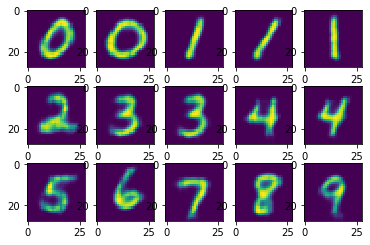

In [7]:
# show prototypes
_, decoding, (r_1, r_2, c) = standard_model(standard_prototype_img)
pred = torch.argmax(c, dim=1)
merged = zip(pred, standard_prototype_img.cpu().detach().numpy())
mergedlist = list(merged)
mergedlist.sort(key=lambda x: x[0])
imgs = np.array([x[1] for x in mergedlist])
show_prototypes(imgs)

## Weights 

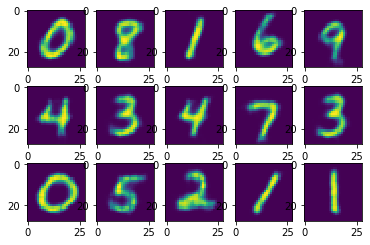

In [16]:
show_prototypes(standard_prototype_img.detach().numpy())

In [20]:
# Weight matrices
learned_weights = standard_model.prototype.linear1.weight.cpu().detach().numpy().T
print("Maximum weights per column correspond to qualitative prototypes!")
print(learned_weights.argmin(axis=1).reshape(3,5))

print("---")
print("Actual weights")
print(np.array_str(learned_weights, precision=3, suppress_small=True))


Maximum weights per column correspond to qualitative prototypes!
[[0 8 1 6 9]
 [4 3 4 7 3]
 [0 5 2 1 1]]
---
Actual weights
[[-4.893  1.006 -1.257  0.786  0.942  1.301 -0.519  0.99  -0.06  -0.614]
 [-0.43   1.333 -0.271  0.754  0.907  0.831  0.438  0.691 -6.1    0.187]
 [ 0.112 -4.833 -0.386  0.193 -0.111  0.344  0.353  0.298 -0.025  1.04 ]
 [-0.298  0.417  0.465 -0.302 -0.369 -0.593 -6.017  0.898 -0.022  0.992]
 [ 0.711  0.408  0.428  0.165 -0.79   1.09   1.466 -0.319  0.403 -5.515]
 [ 0.423 -0.107  0.254  0.854 -4.368 -0.028  0.431 -0.467  1.027 -0.891]
 [ 0.882  0.609 -0.483 -4.13   1.03  -0.597  0.317  0.349  0.059  0.602]
 [ 0.56   1.066  0.791  1.05  -3.25   0.473 -0.744  0.438 -1.158 -0.379]
 [ 0.348 -0.395  0.747 -0.086  0.527  0.108  1.426 -5.667  0.724  0.045]
 [ 0.872  0.488  0.957 -3.491  0.764 -0.973  1.014  0.429  0.208 -1.63 ]
 [-3.358  0.613  0.393  0.991  0.728 -0.953 -0.68  -0.344  1.028 -0.044]
 [ 0.496  0.332  0.902 -0.286  0.681 -5.046 -0.668  0.59   0.418  0.399]


## Test Model

In [8]:
load_and_test(standard_model_path, hierarchical = False)

Testdata loss: 4.020529478788376 acc: 0.9878999999999998 sub acc: 0.0


# Hierarchy model

### Results

In [26]:
prototypes = hierarchy_model.prototype.get_prototypes()
sub_prototypes = hierarchy_model.prototype.get_sub_prototypes()

In [27]:
# convert the prototypes
prototype_img = hierarchy_model.decoder(prototypes.view(-1, 10, 2, 2))
sub_prototype_img = hierarchy_model.decoder(sub_prototypes.view(-1, 10, 2, 2))


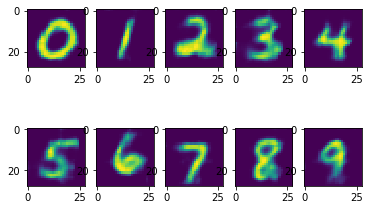

In [28]:
# show prototypes
show_prototypes(prototype_img.cpu().detach().numpy())

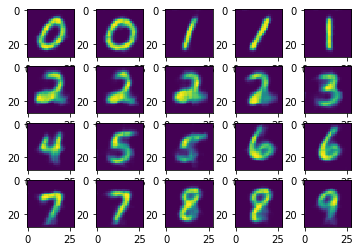

In [29]:
# show sorted subprototypes
_, decoding, (sub_c, sup_c, r1, r2, r3, r4)  = hierarchy_model(sub_prototype_img)
pred = torch.argmax(sub_c, dim=1)
merged = zip(pred, sub_prototype_img.cpu().detach().numpy())
mergedlist = list(merged)
mergedlist.sort(key=lambda x: x[0])
imgs = np.array([x[1] for x in mergedlist])
show_prototypes(imgs)

## Weights

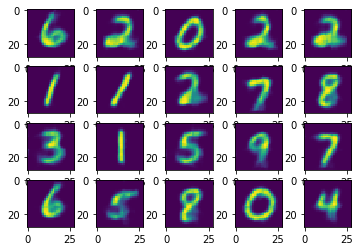

In [31]:
show_prototypes(sub_prototype_img.detach().numpy())

In [32]:
# Weight matrices
learned_weights = hierarchy_model.prototype.linear2.weight.cpu().detach().numpy().T
print("Maximum weights per column (roughly) correspond to qualitative prototypes")
print(learned_weights.argmin(axis=1).reshape(4,5))

print("---")
print("Actual weights")
print(np.array_str(learned_weights, precision=3, suppress_small=True))


Maximum weights per column (roughly) correspond to qualitative prototypes
[[6 2 0 2 1]
 [1 1 7 7 8]
 [3 1 5 9 7]
 [6 5 8 0 4]]
---
Actual weights
[[-0.016  0.47   0.413 -0.069 -0.155  0.311 -0.859 -0.519  0.035  0.356]
 [ 0.293 -0.118 -0.708  0.183 -0.538  0.206  0.491  0.046 -0.068 -0.417]
 [-1.443  0.313 -0.028 -0.107  0.302  0.086 -0.278  0.504 -0.121 -0.14 ]
 [ 0.267 -0.306 -0.82  -0.321  0.227  0.122 -0.094  0.762  0.657 -0.604]
 [ 0.106 -0.266 -0.193  0.322 -0.262 -0.206  0.027 -0.04  -0.012  0.678]
 [-0.189 -0.509 -0.047  0.213  0.412  0.122 -0.002 -0.327  0.276  0.433]
 [ 0.152 -0.939  0.109 -0.334 -0.376  0.067  0.507  0.221 -0.156  0.473]
 [ 0.019 -0.044 -0.261  0.441  0.392 -0.208 -0.382 -0.399 -0.148  0.329]
 [-0.1   -0.117  0.29  -0.313  0.237 -0.3   -0.001 -0.576  0.533 -0.204]
 [ 0.082  0.458  0.147 -0.351  0.495 -0.223  0.109  0.021 -0.757 -0.128]
 [ 0.113 -0.025  0.48  -2.275  0.023  0.237  0.29   0.086  0.255  0.39 ]
 [ 0.227 -0.722  0.142  0.234  0.212  0.411  0.173 

### Test model

In [13]:
load_and_test(hierarchy_model_path, hierarchical = True)

Testdata loss: 6.47433979511261 acc: 0.9885999999999997 sub acc: 0.9902


# Training example

In [14]:
# Global parameters for device and reproducibility
seed = 42
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
hierarchical = True
# Globals
learning_rate = 0.0001
training_epochs = 1500
batch_size = 250

sigma = 4
alpha = 20
n_prototypes = 10
n_sub_prototypes = 20
latent_size = 40
n_classes = 10
save_every = 1
underrepresented_class = -1

lambda_dict = { 
    'lambda_class' : 20, 
    'lambda_class_sup' : 20,
    'lambda_class_sub' : 20,
    'lambda_ae' : 1,
    'lambda_r1' : 1,
    'lambda_r2' : 1,
    'lambda_r3' : 1,
    'lambda_r4' : 1
}

result_directory = './notebook_results'

In [15]:
"""
Args:
    Input:
      Model parameters
        hierarchical : Boolean: Is the model hierarchical?
        n_prototypes : The amount of prototypes. When hierarchical is set to true, this is the amount of superprototypes.
        n_sub_prototypes : The amount of subprototypes. Will be ignored if hierarchical is set to false.
        latent_size : Size of the latent space
        n_classes : Amount of classes 
        lambda_dict : Dictionary containing all necessary lambda's for the weighted loss equation
      Training parameters
        learning_rate : 
        training_epochs : 
        batch_size : 
        save_every : how often to save images and models?
      Miscellaneous
        sigma, alpha : Parameters for elastic deformation. Only used for train data
        directory : Directory to save results, prototype images and final model.
        underrepresented  : The class that is to be downsampled (0.25 to 1 for all other classes)
                    When it is set to -1, no class is downsampled.
"""
train_MNIST(
    hierarchical, 
    n_prototypes, 
    n_sub_prototypes, 
    latent_size, 
    n_classes, 
    lambda_dict, 
    learning_rate, 
    training_epochs, 
    batch_size, 
    save_every, 
    sigma, 
    alpha, 
    seed, 
    result_directory,
    underrepresented_class)

KeyboardInterrupt: 